In [252]:
import numpy as np

In [435]:
def initialize_parameters(layers):
    np.random.seed(11)
    parameters = {}
    for i in range(1, len(layers)):
        parameters[f'W{i}'] = np.random.randn(layers[i], layers[i-1])# * np.sqrt(2/layers[i-1])
        parameters[f'b{i}'] = np.zeros((layers[i], 1))
    return parameters

In [254]:
def relu(X):
    return X * (X > 0)

In [255]:
def forward_propagation(X, parameters, activation='relu', regularization='L2', keep_prob=0.6):
#     print(X.shape)
    cache = {'A0': X}
    A_prev = X
    num_layers = len(parameters)//2
    
    keep_matrix = {}
    
    for i in range(1, num_layers):
        Wi = parameters[f'W{i}']
        bi = parameters[f'b{i}']
        Zi = np.dot(Wi, A_prev) + bi
        cache[f'Z{i}'] = Zi
        if activation == 'relu':
            Ai = relu(Zi)
        # perform dropout
        if regularization == 'dropout':
            keep_matrix[f'L{i}'] = np.random.rand(Ai.shape[0], Ai.shape[1]) < keep_prob
            Ai = Ai * keep_matrix[f'L{i}']
            Ai /= keep_prob
        
        cache[f'A{i}'] = Ai
        A_prev = Ai
    
    Wl = parameters[f'W{num_layers}']
    bl = parameters[f'b{num_layers}']
    Zl = np.dot(Wl, A_prev) + bl
    cache[f'Z{num_layers}'] = Zl
    
    # softmax activation
    Zl = np.e ** Zl
    Al = Zl/np.sum(Zl, axis=0)
    
    cache[f'A{num_layers}'] = Al
    
    return cache, keep_matrix

In [256]:
def compute_cost(Y, Y_cap, parameters, lmbda):
    m = Y.shape[1]
    cost1 = -np.mean(np.log(np.sum(Y * Y_cap, axis=0)))
    # regularization component
    cost2 = 0
    for key in parameters:
        cost2 += (np.linalg.norm(parameters[key]) ** 2)
    return cost1 + cost2*lmbda/2/m

In [257]:
def drelu(X):
    return X > 0.0

In [258]:
def backward_propagation(X, Y, parameters, cache, activation='relu', lmbda=10, 
                         regularization='L2', keep_matrix={}, keep_prob=0.6):
    grads = {}
    num_layers = len(parameters)//2
    dZi = cache[f'A{num_layers}'] - Y
    m = Y.shape[1]
#     print(f'num parameters = {len(parameters)}')
    for i in range(num_layers, 0, -1):
        dWi = np.dot(dZi, cache[f'A{i-1}'].T)/m
        dbi = np.sum(dZi, axis=1).reshape(-1, 1)/m
        grads[f'dW{i}'] = dWi
        grads[f'db{i}'] = dbi
        
        if i == 1:
            break
        # get dZ for previous layer
        dA_previ = np.dot(parameters[f'W{i}'].T, dZi)
        if regularization == 'dropout':
            dA_previ *= keep_matrix[f'L{i-1}']
            dA_previ /= keep_prob
        if activation == 'relu':
            dZ_previ = dA_previ*drelu(cache[f'Z{i-1}'])
        dZi = dZ_previ
    
    for i in range(1, num_layers+1):
        grads[f'dW{i}'] += lmbda/m*parameters[f'W{i}']
        grads[f'db{i}'] += lmbda/m*parameters[f'b{i}']
    
    return grads

In [259]:
def gradient_descent(grads, parameters, learning_rate):
    num_layers = len(parameters)//2
    for i in range(1, num_layers+1):
        parameters[f'W{i}'] -= learning_rate * grads[f'dW{i}']
        parameters[f'b{i}'] -= learning_rate * grads[f'db{i}']
    return parameters

In [260]:
def update_velocity(grads, velocity, beta=0.9):
    for key, val in velocity.items():
        velocity[key] = beta * velocity[key] + (1-beta) * grads[key]
    return velocity

In [261]:
def gradient_descent_with_momentum(velocity, parameters, learning_rate):
    num_layers = len(parameters)//2
    for i in range(1, num_layers+1):
        parameters[f'W{i}'] -= learning_rate * velocity[f'dW{i}']
        parameters[f'b{i}'] -= learning_rate * velocity[f'db{i}']
    return parameters

In [275]:
def training_accuracy(X, Y, parameters, activation='relu'):
    cache, keep_matrix = forward_propagation(X, parameters, activation)
    m = Y.shape[1]
    a = np.argmax(Y, axis=0)
    b = np.argmax(cache[f'A{len(parameters)//2}'], axis=0)
    return np.mean(a == b) * 100

In [263]:
def update_s(grads, s, beta=0.9):
    for key, val in s.items():
        s[key] = beta * s[key] + (1-beta) * (grads[key] ** 2)
    return s

In [264]:
def RMSprop(s, grads, parameters, learning_rate, epsilon):
    num_layers = len(parameters)//2
    for i in range(1, num_layers+1):
        parameters[f'W{i}'] -= learning_rate * grads[f'dW{i}'] / np.sqrt(s[f'dW{i}'] + epsilon)
        parameters[f'b{i}'] -= learning_rate * grads[f'db{i}'] / np.sqrt(s[f'db{i}'] + epsilon)
    return parameters

In [265]:
def adam(s, velocity, parameters, learning_rate, epsilon):
    num_layers = len(parameters)//2
    for i in range(1, num_layers+1):
        parameters[f'W{i}'] -= learning_rate * velocity[f'dW{i}'] / np.sqrt(s[f'dW{i}'] + epsilon)
        parameters[f'b{i}'] -= learning_rate * velocity[f'db{i}'] / np.sqrt(s[f'db{i}'] + epsilon)
    return parameters

In [266]:
def create_mini_batches(X, Y, seed_val=101, mini_batch_size=64):
    np.random.seed(seed_val)
    m = Y.shape[1]
    sample_index = list(range(m))
    np.random.shuffle(sample_index)
    
    mini_batches = []
    num_mini_batches = m // mini_batch_size
    
    for i in range(num_mini_batches):
        Xi = X[:, (mini_batch_size*i):(mini_batch_size*(i+1))]
        Yi = Y[:, (mini_batch_size*i):(mini_batch_size*(i+1))]
        mini_batches.append((Xi, Yi))
    
    if num_mini_batches * mini_batch_size < m:
        Xi = X[:, (num_mini_batches*mini_batch_size):]
        Yi = Y[:, (num_mini_batches*mini_batch_size):]
        mini_batches.append((Xi, Yi))
    
    return mini_batches

In [267]:
def initialize_velocity(layers):
    velocity = {}
    for i in range(1, len(layers)):
        velocity[f'dW{i}'] = np.zeros((layers[i], layers[i-1]))
        velocity[f'db{i}'] = np.zeros((layers[i], 1))
    return velocity

In [436]:
def model_nn(X, Y, iterations=3000, learning_rate=0.009 , C=3, activation='relu', 
             mini_batch_size=64, optimizer='gradient',beta=0.9, 
             epsilon=1e-8, beta1=0.9, beta2=0.999, lmbda=10, regularization='L2', keep_prob=0.6):
    
    if regularization != 'L2': # either dropout or L2
        lmbda = 0
    
    layers = [2, 20, 3, C]
    parameters = initialize_parameters(layers)
    if optimizer == 'momentum':
        velocity = initialize_velocity(layers)
    elif optimizer == 'RMSprop':
        s = initialize_velocity(layers)
    elif optimizer == 'adam':
        velocity = initialize_velocity(layers)
        s = initialize_velocity(layers)
    
    for i in range(iterations):
        mini_batches = create_mini_batches(X, Y, mini_batch_size=mini_batch_size, seed_val=i+1)
        cost = 0
        for Xi, Yi in mini_batches:
            cache, keep_matrix = forward_propagation(Xi, parameters, activation, regularization, keep_prob)
            cost += compute_cost(Yi, cache[f'A{len(parameters)//2}'], parameters, lmbda)
            grads = backward_propagation(Xi, Yi, parameters, cache, activation, lmbda, regularization, 
                                         keep_matrix, keep_prob)
            if optimizer == 'momentum':
                velocity = update_velocity(grads, velocity, beta)
                parameters = gradient_descent_with_momentum(velocity, parameters, learning_rate)
            elif optimizer == 'RMSprop':
                s = update_s(grads, s, beta)
                parameters = RMSprop(s, grads, parameters, learning_rate, epsilon)
            elif optimizer == 'adam':
                velocity = update_velocity(grads, velocity, beta1)
                s = update_s(grads, s, beta2)
                parameters = adam(s, velocity, parameters, learning_rate, epsilon)
            else:
                parameters = gradient_descent(grads, parameters, learning_rate)
        if i % 1000 == 0:
            print(f'cost after {i} iterations = {cost}')
    return parameters

In [278]:
def predict(parameters, X, activation='relu'):
    cache, keep_matrix = forward_propagation(X, parameters, activation)
    num_layers = len(parameters)//2
    return np.argmax(cache[f'A{num_layers}'], axis=0)

In [270]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    print(xx.shape)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y,s=20 ,cmap=plt.cm.Spectral)

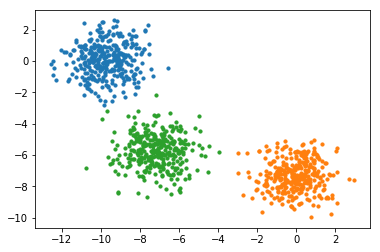

In [361]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where
# generate 2d classification dataset
classes = 3
N = 1000
# X, y = make_blobs(n_samples=600, centers=classes, n_features=2, cluster_std=0.5, random_state=2)
X, y = sklearn.datasets.make_blobs(n_samples=N, random_state=9, n_features=2, centers=classes)
# scatter plot for each class value
for class_value in range(3):
	# select indices of points with the class label
	row_ix = where(y == class_value)
	# scatter plot for points with a different color
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], s=10)
# show plot
pyplot.show()

from sklearn.preprocessing import OneHotEncoder

# one hot encoding
Y = y.reshape((-1,1))
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(Y)
Y_train = enc.transform(Y).toarray().T
Y_train[:,:4]
X, Y = X.T, Y_train

### Regularization in action

In [447]:
parameters = model_nn(X, Y, iterations=30000,C=classes,learning_rate=0.3, 
                      activation='relu', mini_batch_size=Y.shape[1], optimizer='gradient', 
                          beta=0.9, epsilon=1e-8, beta1=0.9, beta2=0.999, lmbda=10, regularization='dropout', keep_prob=0.8)

cost after 0 iterations = 1.0645042572894212
cost after 1000 iterations = 0.2968540611385342
cost after 2000 iterations = 0.2206292758857008
cost after 3000 iterations = 0.2358976563972269
cost after 4000 iterations = 0.219778958327083
cost after 5000 iterations = 0.21121251135647992
cost after 6000 iterations = 0.19563098507295454
cost after 7000 iterations = 0.20042259882427835
cost after 8000 iterations = 0.2402172878343343
cost after 9000 iterations = 0.200984827215849
cost after 10000 iterations = 0.22602610434960876
cost after 11000 iterations = 0.19004145054684518
cost after 12000 iterations = 0.22561131778313923
cost after 13000 iterations = 0.19564352557763523
cost after 14000 iterations = 0.2128872137271691
cost after 15000 iterations = 0.18958079026107796
cost after 16000 iterations = 0.17612546369824494
cost after 17000 iterations = 0.18662115238332413
cost after 18000 iterations = 0.19300500495202966
cost after 19000 iterations = 0.18974335110903773
cost after 20000 iterat

94.7867298578199
(324, 290)


Text(0.5,1,'Decision Boundary for hidden layer size 4')

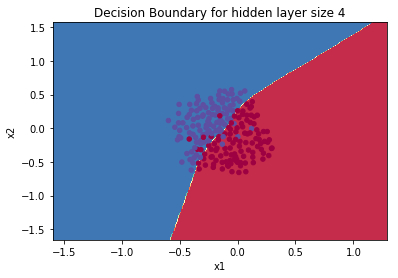

In [448]:
print(training_accuracy(X, Y, parameters))
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, np.argmax(Y, axis=0))
plt.title("Decision Boundary for hidden layer size " + str(4))

### No Regularization taking place : keep_prob is set to 1

In [445]:
parameters = model_nn(X, Y, iterations=30000,C=classes,learning_rate=0.3, 
                      activation='relu', mini_batch_size=Y.shape[1], optimizer='gradient', 
                          beta=0.9, epsilon=1e-8, beta1=0.9, beta2=0.999, lmbda=10, regularization='dropout', keep_prob=1)

cost after 0 iterations = 1.0784505826047441
cost after 1000 iterations = 0.21362667556913398
cost after 2000 iterations = 0.19096600694268442
cost after 3000 iterations = 0.1586015022375065
cost after 4000 iterations = 0.15274341807285072
cost after 5000 iterations = 0.14562497204776462
cost after 6000 iterations = 0.13519702578447076
cost after 7000 iterations = 0.1318768168398022
cost after 8000 iterations = 0.12070879821239183
cost after 9000 iterations = 0.1256892956225717
cost after 10000 iterations = 0.09372316210245973
cost after 11000 iterations = 0.15527690414072473
cost after 12000 iterations = 0.08128511477426902
cost after 13000 iterations = 0.10152863737432702
cost after 14000 iterations = 0.10706412312249737
cost after 15000 iterations = 0.09187865180283608
cost after 16000 iterations = 0.07358004187655344
cost after 17000 iterations = 0.052641196306888856
cost after 18000 iterations = 0.07406824931906694
cost after 19000 iterations = 0.05409674363891005
cost after 20000

95.73459715639811
(324, 290)


Text(0.5,1,'Decision Boundary for hidden layer size 4')

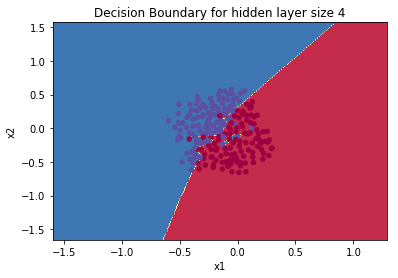

In [446]:
print(training_accuracy(X, Y, parameters))
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, np.argmax(Y, axis=0))
plt.title("Decision Boundary for hidden layer size " + str(4))

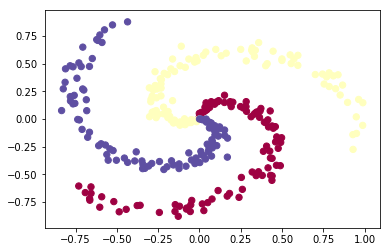

In [330]:
N = 100 # number of points per class
D = 2 # dimensionality
K = classes= 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()
Y = y.reshape((-1,1))
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(Y)
Y_train = enc.transform(Y).toarray().T
Y_train[:,:4]
X, Y = X.T, Y_train

In [388]:
import scipy

In [396]:
def load_2D_dataset():
    data = scipy.io.loadmat('data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y[0], s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y

((2, 211), (2, 211))

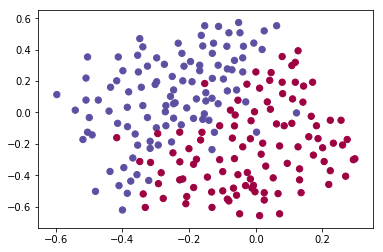

In [416]:
from sklearn.preprocessing import OneHotEncoder

X, y, *z = load_2D_dataset()
X.shape, y.shape, y[0,:5]
# one hot encoding
Y = y.reshape((-1,1))
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(Y)
Y_train = enc.transform(Y).toarray().T
Y_train[:,:4]
X, Y = X, Y_train
classes=2
X.shape, Y.shape